In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

sns.set()
%matplotlib inline

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [3]:
# Read in the data
articles = pd.read_csv('./articles.csv')

In [4]:
articles.head(5)

,category,heading,subheading,author,datetime,article
0,politics,NaN,NaN,NaN,NaN,NaN
1,politics,\nEU's 'most embarrassing' day: How the AstraZ...,\nItalian elite unit found millions of AstraZe...,Bill Gardner,\n24 March 2021 • 7:55pm\n,It was an extraordinary story – the European C...
2,politics,\nEU has a loaded gun on the negotiating table...,\nExports of raw materials to the Pfizer facto...,"James Crisp,",\n26 March 2021 • 12:36pm\n,European Union leaders have left the gun of a ...
3,politics,\nExclusive: Britain to tell Brussels AstraZen...,\nTalks to break stand-off over Covid jabs man...,"James Crisp,",\n27 March 2021 • 9:30pm\n,Britain will this week tell the European Union...
4,politics,\nA year of coronavirus lockdown: How Boris Jo...,\nSome of those closest to the centre of power...,"Gordon Rayner,",\n18 March 2021 • 8:01pm\n,"Ever since his last year, debate has raged a..."


In [5]:
# Look at the shape of the data
articles.shape

(192, 6)

### Data Exploration

In [6]:
# Check for null values
articles.isnull().sum()

category       0
heading       41
subheading    41
author        43
datetime      41
article        8
dtype: int64

#### Since we only need the category and the article, we'll drop all other columns except the two then drop the rows with null values in the remaining two columns

In [7]:
# Drop unnecessary columns
articles = articles.drop(['heading', 'subheading', 'author', 'datetime'], axis=1)

# Drop null rows in the remaining rows
articles = articles.dropna()

In [8]:
# Reset the indices of the articles
articles = articles.reset_index(drop=True)

In [9]:
articles.head()

,category,article
0,politics,It was an extraordinary story – the European C...
1,politics,European Union leaders have left the gun of a ...
2,politics,Britain will this week tell the European Union...
3,politics,"Ever since his last year, debate has raged a..."
4,politics,Jean-Claude Juncker has attacked Ursula von de...


<AxesSubplot:>

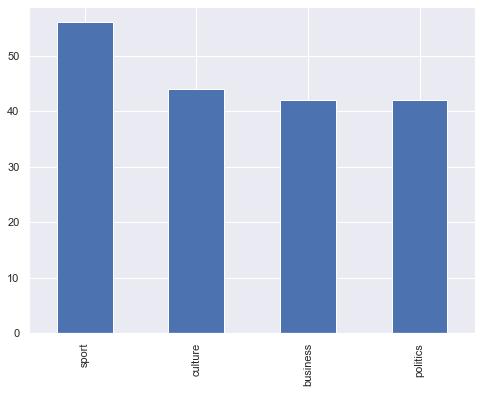

In [10]:
# Look at the distribution of categories in the articles
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
articles['category'].value_counts().plot(kind='bar', ax=ax)

### Data Preprocessing

In [11]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
STOPWORDS = stopwords.words('english')

In [12]:
# Dictionary mapping word contractions to their full words
contractions = { 
    "ain't": "are not","'s":" is","aren't": "are not",
     "can't": "cannot","can't've": "cannot have",
     "'cause": "because","could've": "could have","couldn't": "could not",
     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
     "hasn't": "has not","haven't": "have not","he'd": "he would",
     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
     "it'd": "it would","it'd've": "it would have","it'll": "it will",
     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
     "mayn't": "may not","might've": "might have","mightn't": "might not", 
     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
     "mustn't've": "must not have", "needn't": "need not",
     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
     "she'll": "she will", "she'll've": "she will have","should've": "should have",
     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
     "there'd've": "there would have", "they'd": "they would",
     "they'd've": "they would have","they'll": "they will",
     "they'll've": "they will have", "they're": "they are","they've": "they have",
     "to've": "to have","wasn't": "was not","we'd": "we would",
     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
     "what'll've": "what will have","what're": "what are", "what've": "what have",
     "when've": "when have","where'd": "where did", "where've": "where have",
     "who'll": "who will","who'll've": "who will have","who've": "who have",
     "why've": "why have","will've": "will have","won't": "will not",
     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
     "y'all'd've": "you all would have","y'all're": "you all are",
     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
     "you'll": "you will","you'll've": "you will have", "you're": "you are",
     "you've": "you have"
}

In [13]:
# Remove punctutation marks, stopwords, emojis, urls, convert to lowercase, expand contractions 
def preprocess_article(article):
    res_article = []
    lemmatizer = WordNetLemmatizer()
    
    for word in article.split():        
        
        # Expand Contractions
        word = contractions.get(word.lower(), word)
        
        # Remove stopwords
        if word not in STOPWORDS:
            
            # Remove url
            word = re.sub(r'http\S+', '', word)
    
            emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
            word = emoji_clean.sub(r'', word)
            
             # Remove punctuation
            word = re.sub(r'[^\w\s]', '', word)
            
            # Convert to lowercase
            word = word.lower()
            
            # Lemmatize the word
            word = lemmatizer.lemmatize(word, pos='v')
        
            if word != '':
                res_article.append(word)
    

    return ' '.join([word for word in res_article]) 

In [14]:
articles['article'] = articles['article'].apply(lambda x: preprocess_article(x))

In [15]:
articles.head()

,category,article
0,politics,it extraordinary story european commission fin...
1,politics,european union leaders leave gun vaccine expor...
2,politics,britain week tell european union must take acc...
3,politics,ever since last year debate rag extent experie...
4,politics,jeanclaude juncker attack ursula von der leyen...


### Further Data Exploration

In [16]:
from nltk.probability import FreqDist

In [17]:
article_tokens = [word for article in articles['article'] for word in article.split()]
fdist = FreqDist(article_tokens)

<AxesSubplot:>

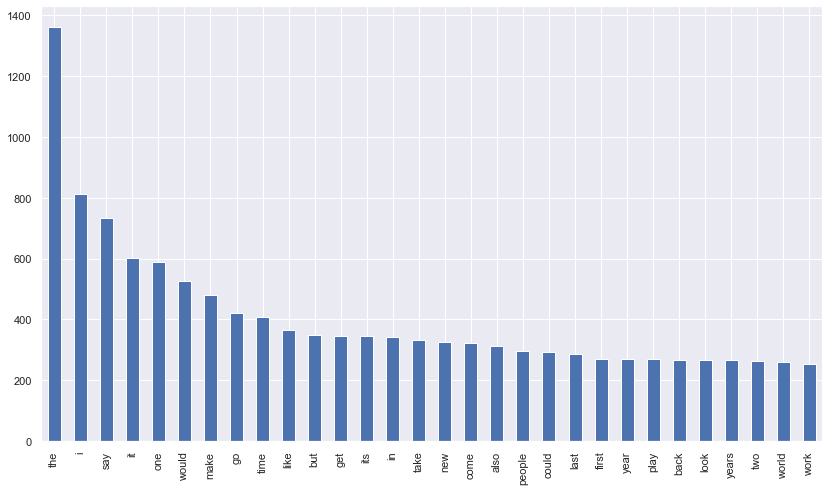

In [18]:
fig = plt.figure(figsize=(14,8))
ax = fig.gca()

pd.Series(dict(fdist.most_common(30))).plot(kind='bar', ax=ax)

In [19]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

In [20]:
def display_cloud(label):
    plt.subplots(figsize=(13,13))
    text = articles[articles['category']==label]["article"].tolist()
    wc = WordCloud(
      stopwords=STOPWORDS,
      background_color='black',
      colormap='Blues',
      collocations=False,
      width=1800,
      height=800,
    )
    wc.generate(' '.join(text))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.title(label,fontsize=24)
    plt.show()

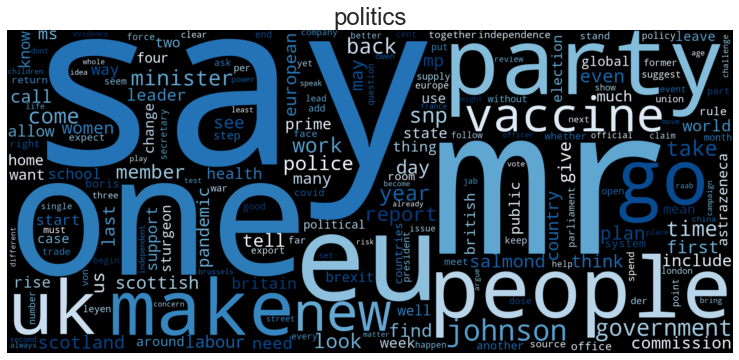

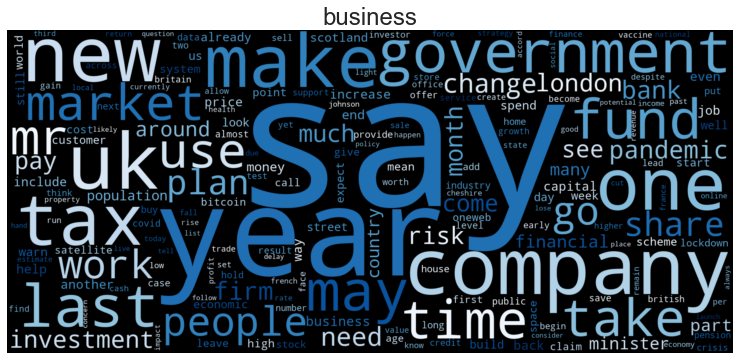

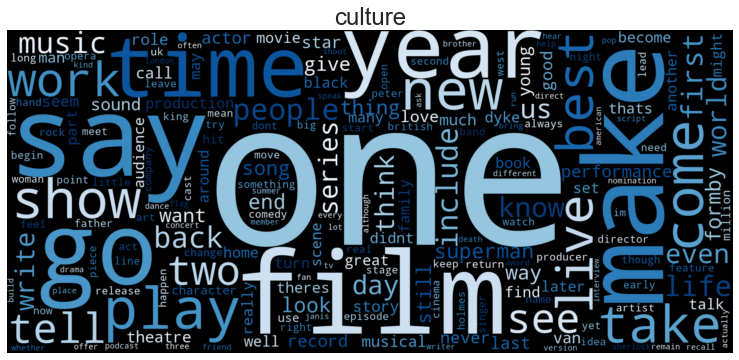

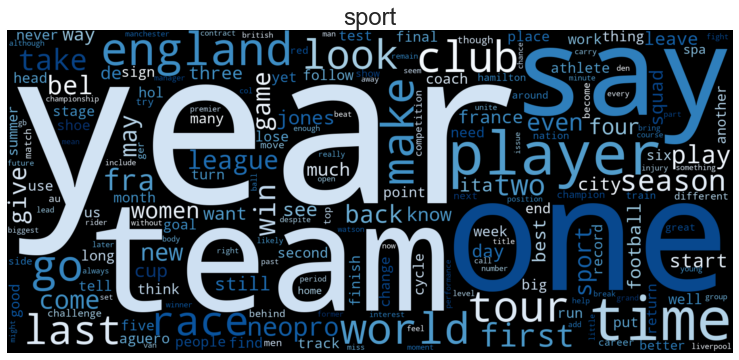

In [21]:
for category in articles['category'].unique():
    display_cloud(category)

In [22]:
articles['article'][0]

'it extraordinary story european commission find astrazenecas secret stockpile vaccines reserve britain during surprise raid weekend elite unit italian military police act eu order the discovery appear confirm eus longheld suspicion astrazeneca give uk special treatment secretly export dose home country fail deliver contract agree brussels yet eu officials allegation brief continental press simply was not true in fact dose discover italian factory destine eu itself remainder head poorer countries across world one former europe minister call possibly most embarrass day eus history italys la stampa newspaper report italian officer dose astrazeneca vaccine put vials label the raid carry nas elite unit carabinieri part arm force usually investigate criminal syndicate suspect counterfeit food wine medicine after inspect company record officer roughly half astrazenecas delivery shortfall eu eu source brief newspaper shipment think secretly bind uk despite company fall far short promise deliv

### Feature Engineering

In [23]:
#TF IDF for article column
from sklearn.feature_extraction.text import TfidfVectorizer

In [24]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
tfidf_article = tfidf_vectorizer.fit_transform(articles['article'])

In [25]:
pickle.dump(tfidf_vectorizer, open('tfidf_vectorizer.pkl', 'wb'))

In [26]:
#tf-idf output vectors
from sklearn.decomposition import PCA 

In [27]:
tfidf_article.toarray().shape

(184, 18338)

In [28]:
tfidf_pca = PCA(n_components = 2) 
tfidf_pca_comp = tfidf_pca.fit_transform(tfidf_article.toarray())

In [29]:
tfidf_pca_comp.shape

(184, 2)

In [30]:
pickle.dump(tfidf_pca, open('tfidf_pca.pkl', 'wb'))

In [31]:
from sklearn.cluster import KMeans

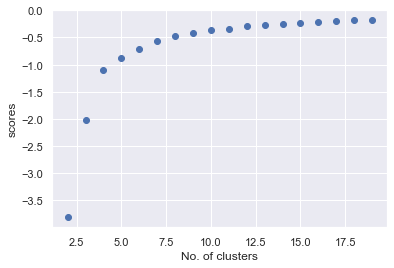

In [32]:
clusters=[]
kmeans_scores=[]

K = range(2, 20)
for k in K:
    k_means = KMeans(n_clusters=k)
    k_means.fit(tfidf_pca_comp)
    kmeans_scores.append(k_means.score(tfidf_pca_comp))
    clusters.append(k)
plt.scatter(clusters,kmeans_scores)
plt.xlabel("No. of clusters")
plt.ylabel("scores")
plt.show()

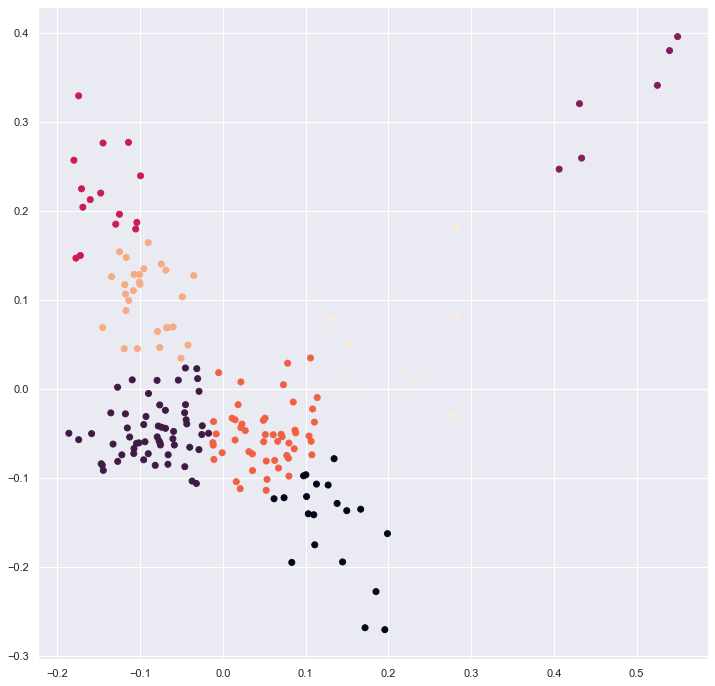

In [33]:
k_means = KMeans(n_clusters=7)
k_means.fit(tfidf_pca_comp)
pred=k_means.predict(tfidf_pca_comp)
plt.figure(figsize=(12,12))
plt.scatter(tfidf_pca_comp[:,0],tfidf_pca_comp[:,1],c=pred)
# sns.scatterplot(x=tfidf_pca_comp[:,0], y=tfidf_pca_comp[:,0], hue=pred)
plt.show()

In [34]:
import pickle

In [35]:
# Save the kmeans model for deployment
pickle.dump( k_means, open('kmeans_model.pkl', 'wb'))

In [36]:
articles['clusters'] = pred
articles.head()

,category,article,clusters
0,politics,it extraordinary story european commission fin...,2
1,politics,european union leaders leave gun vaccine expor...,2
2,politics,britain week tell european union must take acc...,2
3,politics,ever since last year debate rag extent experie...,0
4,politics,jeanclaude juncker attack ursula von der leyen...,2


In [37]:
articles['clusters'].unique()

array([2, 0, 1, 4, 6, 5, 3])

In [38]:
#Articles in cluster 0
articles[articles['clusters'] == 0][['category', 'article', 'clusters']]

,category,article,clusters
3,politics,ever since last year debate rag extent experie...,0
7,politics,its clear nicola sturgeon damage goods days nu...,0
124,business,savers max need savvy put money bad decision c...,0
125,business,david cameron face probe standards committee l...,0
126,business,with two weeks go tax year end april 5 time fi...,0
128,business,a raft impact pensioners savers investors self...,0
129,business,swiss bank reputation crushingly dull thats ki...,0
136,business,scotland attempt turn back clock save economy ...,0
137,business,fewer 50 promise 2000 new job create result ta...,0
141,business,why fuss subject fierce debate north border ap...,0


<AxesSubplot:>

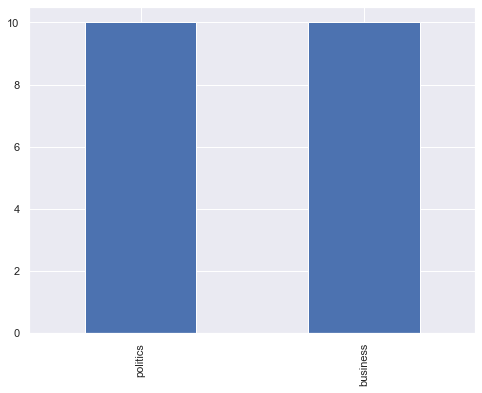

In [39]:
# Look at the distribution of categories in the articles in cluster 0
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
articles[articles['clusters'] == 0]['category'].value_counts().plot(kind='bar', ax=ax)

In [40]:
#Articles in cluster 1
articles[articles['clusters'] == 1][['category', 'article', 'clusters']]

,category,article,clusters
5,politics,we know it dont we things go school would poli...,1
8,politics,when police tell owen paterson wife rise find ...,1
14,culture,comedians joe wilkinson david earl poppy hills...,1
15,culture,at 18 years old actor nicholas rowe get live d...,1
16,culture,the show go on soon accord lockdown socially d...,1
17,politics,in months take school metoo moment go undergro...,1
18,culture,intimacy grandeur seem least likely bedfellows...,1
19,culture,the biennial rednosed entertainment extravagan...,1
20,culture,female performers always pressure look good ma...,1
21,culture,do prince harry meghan markle oscar sight the ...,1


<AxesSubplot:>

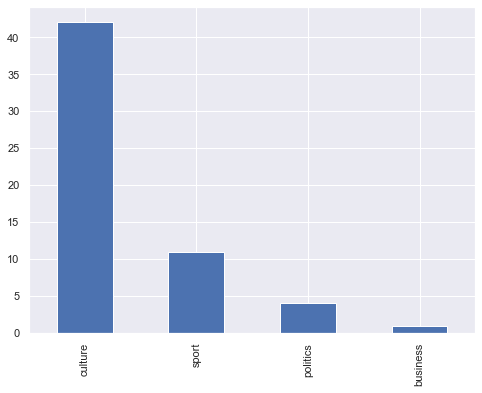

In [41]:
# Look at the distribution of categories in the articles in cluster 1
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
articles[articles['clusters'] == 1]['category'].value_counts().plot(kind='bar', ax=ax)

In [42]:
#Articles in cluster 2
articles[articles['clusters'] == 2][['category', 'article', 'clusters']]

,category,article,clusters
0,politics,it extraordinary story european commission fin...,2
1,politics,european union leaders leave gun vaccine expor...,2
2,politics,britain week tell european union must take acc...,2
4,politics,jeanclaude juncker attack ursula von der leyen...,2
176,politics,ursula von der leyen plan quit last weeks coro...,2
179,politics,divisions eus vaccination crisis lay bare ursu...,2


<AxesSubplot:>

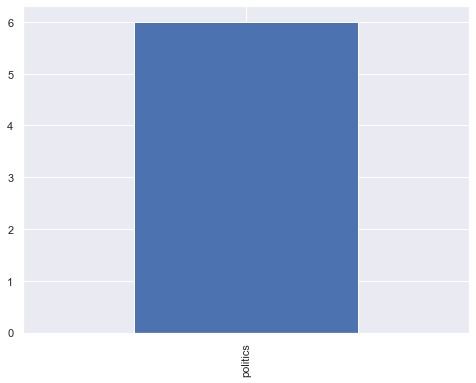

In [43]:
# Look at the distribution of categories in the articles in cluster 2
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
articles[articles['clusters'] == 2]['category'].value_counts().plot(kind='bar', ax=ax)

In [44]:
#Articles in cluster 3
articles[articles['clusters'] == 3][['category', 'article', 'clusters']]

,category,article,clusters
71,sport,just big stadiums might represent future women...,3
78,sport,five years 62 test tenure head coach eddie jon...,3
83,sport,welcome mad bad world birmingham city volatile...,3
86,sport,the prospect first ever official womens club w...,3
89,sport,eddie jones see film before uninspiring plot m...,3
90,sport,manchester city commission statue honour sergi...,3
92,sport,football club must allocate money look youngst...,3
97,sport,team gb england head coach hege riise say big ...,3
99,sport,ole gunnar solskjaer choose dean henderson dav...,3
104,sport,whatever allegiance years six nations cannot s...,3


<AxesSubplot:>

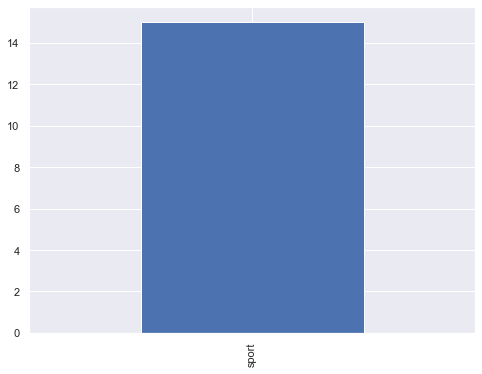

In [45]:
# Look at the distribution of categories in the articles in cluster 3
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
articles[articles['clusters'] == 3]['category'].value_counts().plot(kind='bar', ax=ax)

In [46]:
#Articles in cluster 4
articles[articles['clusters'] == 4][['category', 'article', 'clusters']]

,category,article,clusters
6,politics,sometimes politics convenient leader retain un...,4
9,politics,one respect universities release guide play ru...,4
11,business,a loss 8pc share doesnt sound like much result...,4
12,business,will company survive that question force ask s...,4
27,business,limit high street footfall reduce loan book un...,4
50,culture,with yeardelayed london mayoral election month...,4
55,culture,how museums survive financial apocalypse bring...,4
57,sport,british cycle uk antidoping say try assist wor...,4
62,sport,set 1913 journalist karel van wijnendaele tour...,4
112,business,after year roll lockdowns shutter offices ligh...,4


<AxesSubplot:>

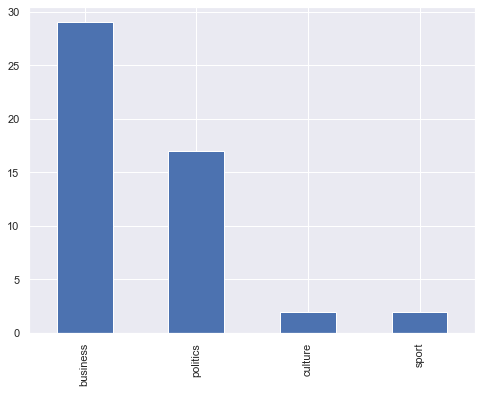

In [47]:
# Look at the distribution of categories in the articles in cluster 4
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
articles[articles['clusters'] == 4]['category'].value_counts().plot(kind='bar', ax=ax)

In [48]:
#Articles in cluster 5
articles[articles['clusters'] == 5][['category', 'article', 'clusters']]

,category,article,clusters
58,sport,the grand national back it best know steeplech...,5
64,sport,andy murray suffer another injury setback forc...,5
66,sport,as thousands golfers return course across engl...,5
67,sport,billy joe saunders unbeaten british fighter fa...,5
69,sport,dinara safina stand front bathroom mirror look...,5
70,sport,if preseason test hint mercedes lewis hamilton...,5
74,sport,with eddie jones maro itoje would happily volu...,5
75,sport,before start new county cricket season april 8...,5
76,sport,birmingham city manager carla ward slam side d...,5
77,sport,jofra archer suffer cut hand drop fish tank ba...,5


<AxesSubplot:>

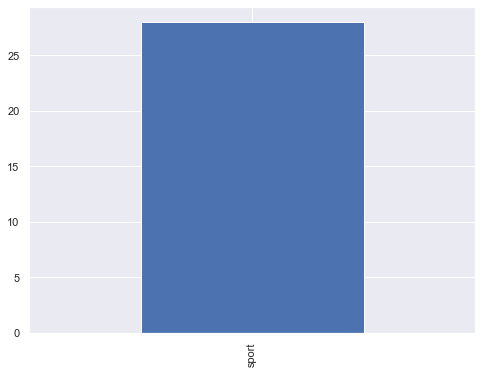

In [49]:
# Look at the distribution of categories in the articles in cluster 5
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
articles[articles['clusters'] == 5]['category'].value_counts().plot(kind='bar', ax=ax)

In [50]:
#Articles in cluster 6
articles[articles['clusters'] == 6][['category', 'article', 'clusters']]

,category,article,clusters
10,politics,infections run 40000 day france in poland rate...,6
13,politics,the world need global settlement like forge se...,6
144,business,emmanuel macron lose control germany place cou...,6
155,politics,until early 18th century cross border scotland...,6
156,business,the pandemic like long war overconfident early...,6
157,politics,the british governments handle pandemic includ...,6
178,politics,the covid19 pandemic biggest challenge global ...,6


<AxesSubplot:>

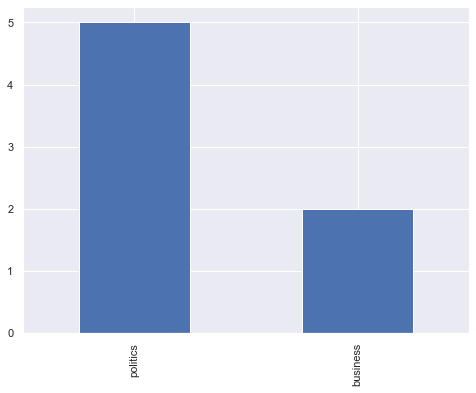

In [51]:
# Look at the distribution of categories in the articles in cluster 6
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
articles[articles['clusters'] == 6]['category'].value_counts().plot(kind='bar', ax=ax)

In [52]:
articles.to_csv('clustered_articles.csv', index=False)

In [53]:
articles.head()

,category,article,clusters
0,politics,it extraordinary story european commission fin...,2
1,politics,european union leaders leave gun vaccine expor...,2
2,politics,britain week tell european union must take acc...,2
3,politics,ever since last year debate rag extent experie...,0
4,politics,jeanclaude juncker attack ursula von der leyen...,2
